## Features in computer vision

Features are image locations that are "easy" to find in the future.  Indeed, one of the early feature detection techniques Lucas-Kanade, sometimes called Kanade-Lucas-Tomasi or KLT features come from a seminal paper called "Good features to track".

Edges find brightness discontinuities in an image, features find distinctive regions. There are a bunch of different feature detectors and these all have some characteristics in common: they should be quick to find, and things that are close in image-space are close in feature-space (that is, the feature representation of an object looks like the feature representation of objects that look like that object).

There is a more in depth *features in OpenCV* set of tutorials here [http://docs.opencv.org/3.1.0/db/d27/tutorial_py_table_of_contents_feature2d.html] and I'll link to various parts of that as appropriate: for more background though, go and work through the whole thing.

In [35]:
# our usual set of includes
# these imports let you use opencv
import cv2 #opencv itself
import common #some useful opencv functions
import video # some video stuff
import numpy as np # matrix manipulations

#the following are to do with this interactive notebook code
%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook


input_image=cv2.imread('noidea.jpg')

## Corner detectors
If you think of edges as being lines, then corners are an obvious choice for features as they represent the intersection of two lines. One of the earlier corner detectors was introduced by Harris, and it is still a very effective corner detector that gets used quite a lot: it's reliable and it's fast. There's a tutorial explaining how Harris works on the OpenCV site : [http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html]

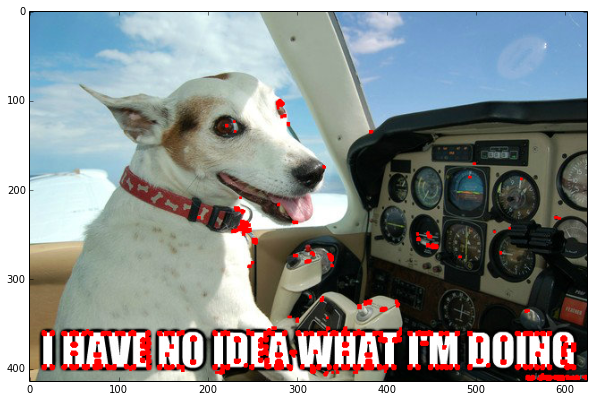

In [36]:
harris_test=input_image.copy()
#greyscale it
gray = cv2.cvtColor(harris_test,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
blocksize=4 # 
kernel_size=3 # sobel kernel: must be odd and fairly small

# run the harris corner detector
dst = cv2.cornerHarris(gray,blocksize,kernel_size,0.05) # parameters are blocksize, Sobel parameter and Harris threshold

#result is dilated for marking the corners, this is visualisation related and just makes them bigger
dst = cv2.dilate(dst,None)
#we then plot these on the input image for visualisation purposes, using bright red
harris_test[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(cv2.cvtColor(harris_test, cv2.COLOR_BGR2RGB))

Properly speaking the Harris Corner detection is more like a Sobel operator - indeed it is very much like a sobel operator. It doesn't really return a set of features, instead it is a filter which gives a strong response on corner-like regions of the image. We can see this more clearly if we look at the Harris output from the cell above (dst is the Harris response, before thresholding). Well we can kind-of see. You should be able to see that there are slightly light places in the image where there are corner like features, and that there are really light parts of the image around the black and white corners of the writing 

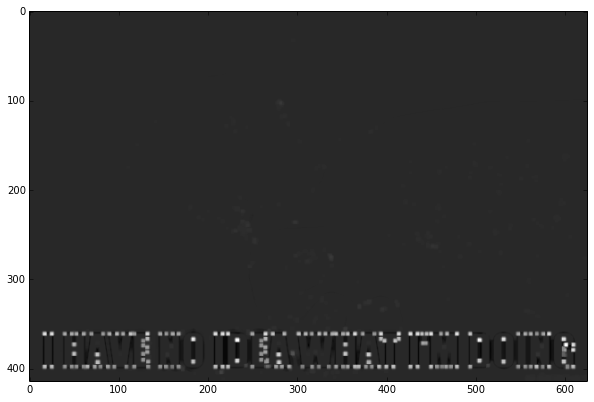

In [37]:
plt.imshow(dst,cmap = 'gray') 


## Moving towards feature space
When we consider modern feature detectors there are a few things we need to mention. What makes a good feature includes the following: 

* Repeatability (got to be able to find it again)
* Distinctiveness/informativeness (features representing different things need to be different)
* Locality (they need to be local to the image feature and not, like, the whole image)
* Quantity (you need to be able to find enough of them for them to be properly useful)
* Accuracy (they need to accurately locate the image feature)
* Efficiency (they've got to be computable in reasonable time)

This comes from a good survey which you can find here (and which I'd thoroughly recommend reading if you're doing feature detection work) [http://campar.in.tum.de/twiki/pub/Chair/TeachingWs09MATDCV/FT_survey_interestpoints08.pdf]

**Note:** some of the very famous feature detectors (SIFT/SURF and so on) are around, but aren't in OpenCV by default due to patent issues. You can build them for OpenCV if you want - or you can find other implementations (David Lowe's SIFT implementation works just fine). Just google for instructions.  For the purposes of this tutorial (and to save time) we're only going to look at those which are actually in OpenCV.

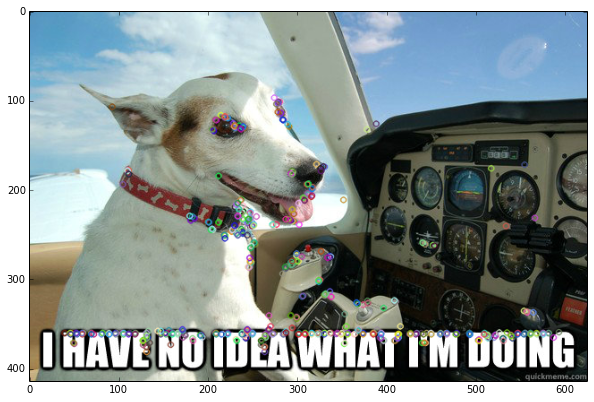

In [38]:
orbimg=input_image.copy()

orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(orbimg,None)
# compute the descriptors with ORB
kp, des = orb.compute(orbimg, kp)
# draw keypoints
cv2.drawKeypoints(orbimg,kp,orbimg)

plt.imshow(cv2.cvtColor(orbimg, cv2.COLOR_BGR2RGB))

## Matching features
Finding features is one thing but actually we want to use them for matching. 
First let's get something where we know there's going to be a match


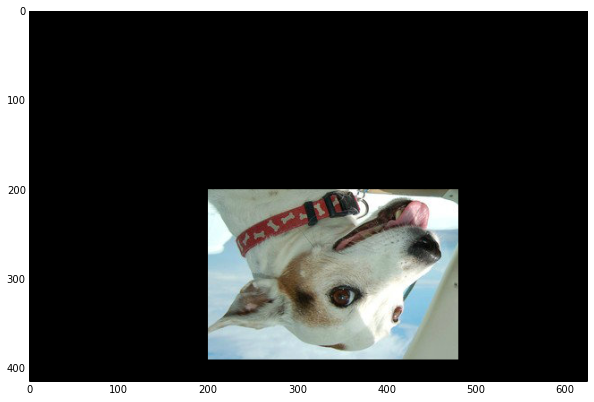

In [39]:
img2match=np.zeros(input_image.shape,np.uint8)
dogface=input_image[60:250, 70:350] # copy out a bit
img2match[60:250,70:350]=[0,0,0] # blank that region
dogface=cv2.flip(dogface,0) #flip the copy
img2match[200:200+dogface.shape[0], 200:200+dogface.shape[1]]=dogface # paste it back somewhere else
plt.imshow(cv2.cvtColor(img2match, cv2.COLOR_BGR2RGB))

## Matching keypoints

The feature matching function (in this case Orb) detects and then computes keypoint descriptors. These are a higher dimensional representation of the image region immediately around a point of interest (sometimes literally called "interest points"). 

These higher-dimensional representations can then be matched; the strength you gain from matching these descriptors rather than image regions directly is that they have a certain invariance to transformations (like rotation, or scaling). OpenCV providers matcher routines to do this, in which you can specify the distance measure to use.

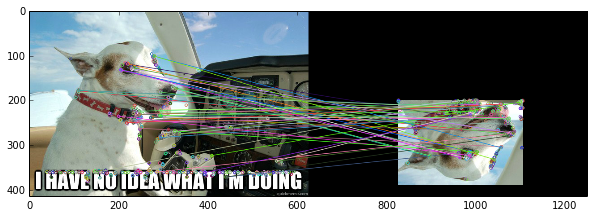

In [44]:

kp2 = orb.detect(img2match,None)
# compute the descriptors with ORB
kp2, des2 = orb.compute(img2match, kp2)
# create BFMatcher object: this is a Brute Force matching object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des,des2)
 
# Sort them by distance between matches in feature space - so the best matches are first.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 50 matches.
oimg = cv2.drawMatches(orbimg,kp,img2match,kp2,matches[:50], orbimg)
 
plt.imshow(cv2.cvtColor(oimg, cv2.COLOR_BGR2RGB))


As you can see there are some false matches, but it's fairly clear that most of the matched keypoints found are actual matches between image regions on the dogface.

To be more precise about our matching we could choose to enforce **homography** constraints, which looks for features than sit on the same plane. If you want to investigate that check out this tutorial online:
[http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html]

[Previous](3%20Image%20stats%20and%20image%20processing.ipynb) [Next](5%20detecting%20faces%20and%20other%20things.ipynb)